In [426]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.stats import randint as sp_randint

### EDL - Univariance Analysis

In [427]:
df = pd.read_csv('concrete.csv')

In [428]:
df.shape

(1030, 9)

In [429]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [431]:
df.nunique()

cement          278
slag            185
ash             156
water           195
superplastic    111
coarseagg       284
fineagg         302
age              14
strength        845
dtype: int64

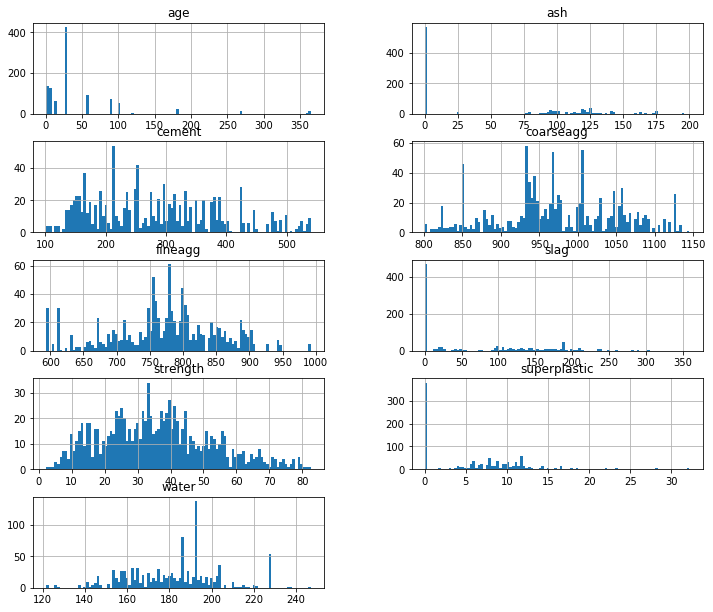

In [432]:
df.hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));
#There are few outliers in age. There are lot of 0 in ash, slag, superplastic.
#But, it is very likely that 

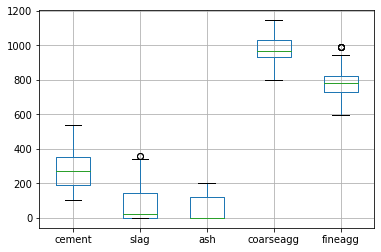

In [433]:
df.boxplot(column=["cement","slag","ash","coarseagg","fineagg"])
#Few outliers in fineagg

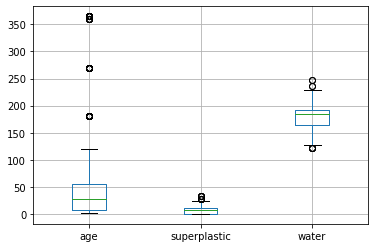

In [434]:
df.boxplot(column=["age", "superplastic", "water"])
#There are few outliers in age, superplastic, water

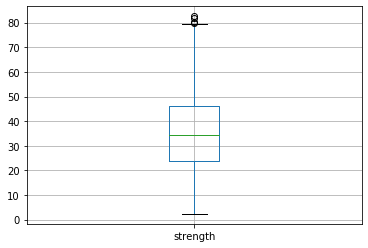

In [435]:
df.boxplot(column=["strength"])

In [436]:
df.isnull().sum()
#There are no null values.

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

### Some Feature Engineering

In [437]:
# let us drop outliers that are more than 50% + 2 * standard deviation
df = df[df.age < 154]
df = df[df.superplastic < 18.36]
df = df[df.water < 227]
# Let us try to add two aggregates into 1 and drop individual aggregate
# Log transform of slag, ash and superplastic may not be needed
df['aggregate'] = df['coarseagg'] + df['fineagg']
df['slag_log+1'] = (df['slag']+1).transform(np.log)
df['ash_log+1'] = (df['ash']+1).transform(np.log)
df['superplastic_log+1'] = (df['superplastic']+1).transform(np.log)
df['water_log'] = (df['water']).transform(np.log)
df.drop(['coarseagg', 'fineagg','slag','ash','superplastic','water'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              912 non-null    float64
 1   age                 912 non-null    int64  
 2   strength            912 non-null    float64
 3   aggregate           912 non-null    float64
 4   slag_log+1          912 non-null    float64
 5   ash_log+1           912 non-null    float64
 6   superplastic_log+1  912 non-null    float64
 7   water_log           912 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 64.1 KB


In [438]:
df.head(25)

,cement,age,strength,aggregate,slag_log+1,ash_log+1,superplastic_log+1,water_log
0,141.3,28,29.89,1720.3,5.361292,0.000000,0.000000,5.315666
1,168.9,14,23.51,1877.0,3.765840,4.830711,2.468100,5.064492
2,250.0,28,29.22,1818.1,0.000000,4.571613,1.871802,5.233245
4,154.8,28,18.29,1744.1,5.217107,0.000000,2.312535,5.264243
5,255.0,90,21.86,1834.8,0.000000,0.000000,0.000000,5.257495
6,166.8,7,15.75,1668.2,5.526249,0.000000,0.000000,5.315666
7,251.4,56,36.64,1786.1,0.000000,4.781641,2.001480,5.239098
8,296.0,28,21.65,1850.0,0.000000,0.000000,0.000000,5.257495
9,155.0,28,28.99,1579.0,5.220356,4.969813,2.302585,5.267858
10,151.8,28,36.35,1638.6,5.187944,4.939497,2.960105,5.120983


In [439]:
for i in list(df.columns):
    print(df[i].value_counts())

362.6    20
425.0    15
251.4    15
446.0    14
250.0    13
         ..
136.4     1
266.2     1
299.8     1
252.1     1
272.6     1
Name: cement, Length: 265, dtype: int64
28     401
3      129
7      116
56      86
14      62
100     52
90      44
91      17
120      3
1        2
Name: age, dtype: int64
33.40    6
31.35    4
35.30    4
71.30    4
79.30    4
        ..
21.07    1
24.29    1
56.62    1
25.51    1
15.75    1
Name: strength, Length: 759, dtype: int64
1700.5    25
1738.0    16
1739.2    15
1679.0    14
1743.0    13
          ..
1737.2     1
1778.5     1
1685.7     1
1815.0     1
1739.5     1
Name: aggregate, Length: 317, dtype: int64
0.000000    430
5.247024     25
4.675629     15
3.218876     14
3.044522     12
           ... 
5.121580      1
4.465908      1
4.727388      1
5.093750      1
4.928702      1
Name: slag_log+1, Length: 170, dtype: int64
0.000000    459
4.781641     20
4.955827     16
3.238678     15
4.382027     14
           ... 
4.338597      1
4.506454     

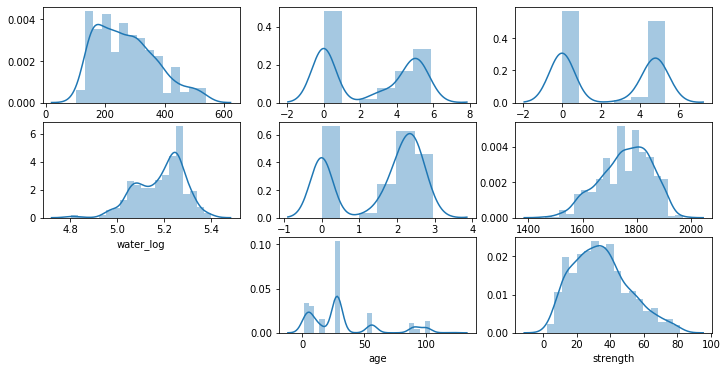

In [440]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 3, 1)
sns.distplot(df['cement'])
plt.subplot(3, 3, 2)
sns.distplot(df['slag_log+1'])
plt.subplot(3, 3, 3)
sns.distplot(df['ash_log+1'])
plt.subplot(3, 3, 4)
sns.distplot(df['water_log'])
plt.subplot(3, 3, 5)
sns.distplot(df['superplastic_log+1'])
plt.subplot(3,3,6)
sns.distplot(df['aggregate'])
#plt.subplot(3, 3, 6)
#sns.distplot(df['coarseagg'])
#plt.subplot(3, 3, 7)
#sns.distplot(df['fineagg'])
plt.subplot(3, 3, 8)
sns.distplot(df['age'])
plt.subplot(3, 3, 9)
sns.distplot(df['strength'])
plt.show()

# slag, ash, superplastic, age has 0 values which needs to addressed

In [441]:
df.head(10)

,cement,age,strength,aggregate,slag_log+1,ash_log+1,superplastic_log+1,water_log
0,141.3,28,29.89,1720.3,5.361292,0.000000,0.000000,5.315666
1,168.9,14,23.51,1877.0,3.765840,4.830711,2.468100,5.064492
2,250.0,28,29.22,1818.1,0.000000,4.571613,1.871802,5.233245
4,154.8,28,18.29,1744.1,5.217107,0.000000,2.312535,5.264243
5,255.0,90,21.86,1834.8,0.000000,0.000000,0.000000,5.257495
6,166.8,7,15.75,1668.2,5.526249,0.000000,0.000000,5.315666
7,251.4,56,36.64,1786.1,0.000000,4.781641,2.001480,5.239098
8,296.0,28,21.65,1850.0,0.000000,0.000000,0.000000,5.257495
9,155.0,28,28.99,1579.0,5.220356,4.969813,2.302585,5.267858
10,151.8,28,36.35,1638.6,5.187944,4.939497,2.960105,5.120983


### Bi-variate analysis

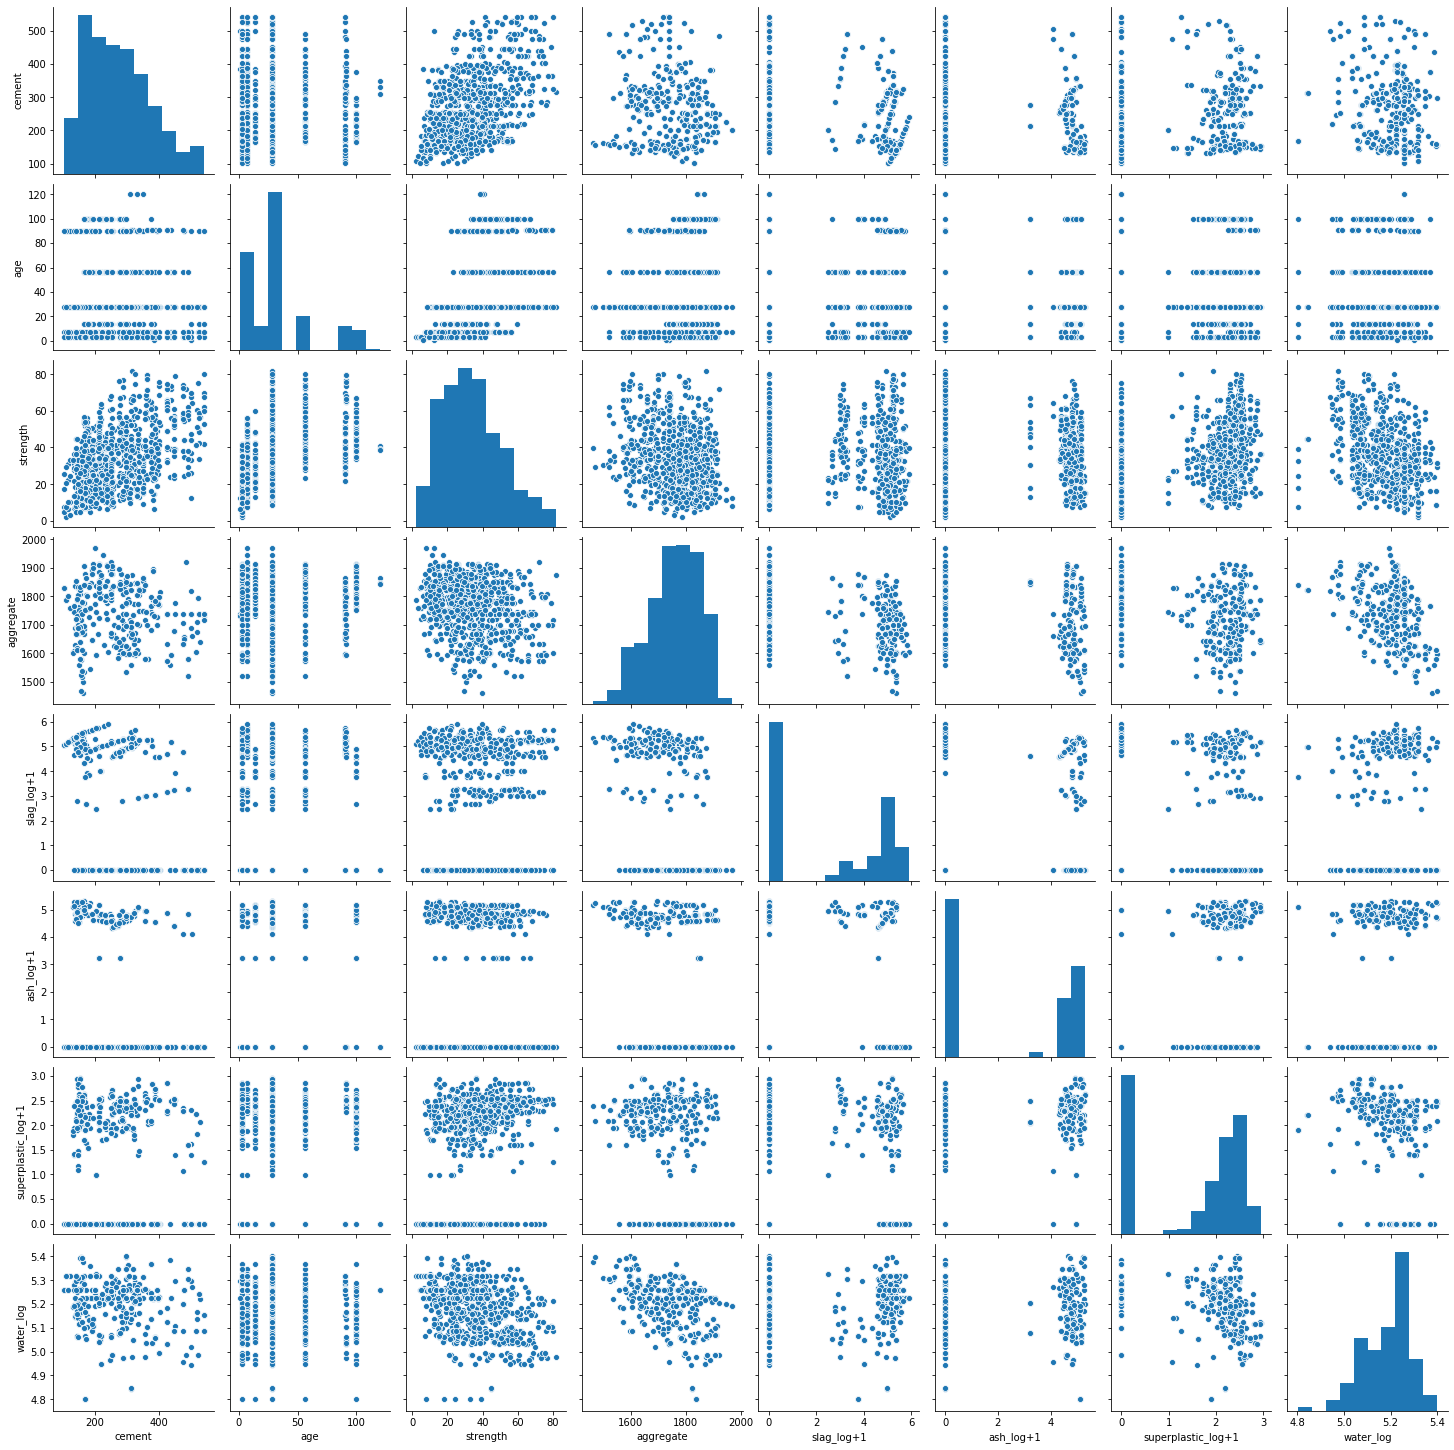

In [442]:
sns.pairplot(df)

In [443]:
df.corr()
#superplastic seems to have somewhat higher correlation with trength. 

,cement,age,strength,aggregate,slag_log+1,ash_log+1,superplastic_log+1,water_log
cement,1.000000,-0.046903,0.474312,-0.252291,-0.206737,-0.324815,-0.042388,-0.097117
age,-0.046903,1.000000,0.520705,0.087325,-0.034775,0.081832,0.089954,-0.075795
strength,0.474312,0.520705,1.000000,-0.257522,0.213742,-0.012705,0.393984,-0.384558
aggregate,-0.252291,0.087325,-0.257522,1.000000,-0.480321,0.023786,-0.151219,-0.379724
slag_log+1,-0.206737,-0.034775,0.213742,-0.480321,1.000000,-0.224894,0.137984,-0.005089
ash_log+1,-0.324815,0.081832,-0.012705,0.023786,-0.224894,1.000000,0.612514,-0.262945
superplastic_log+1,-0.042388,0.089954,0.393984,-0.151219,0.137984,0.612514,1.000000,-0.539942
water_log,-0.097117,-0.075795,-0.384558,-0.379724,-0.005089,-0.262945,-0.539942,1.000000


### Train Test Split

In [444]:
X = df.drop("strength" , axis=1)
y = df.pop("strength")

In [445]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

### Linear Regression

In [446]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [447]:
print('Coefficient b1', regressor.coef_)
print('Intercept b0', regressor.intercept_)

Coefficient b1 [ 7.77312468e-02  3.09390349e-01 -2.96304246e-02  1.53322400e+00
  4.47137163e-02  2.33981736e+00 -4.69167237e+01]
Intercept b0 291.34503124688047


In [455]:
y_pred = regressor.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
print("Root Mean Square Error: ", rmse)
print("R2 Score:", r2)

Root Mean Square Error:  8.940910570826174
R2 Score: 0.7361530647106108


### Polynomial Regression (degree = 2)

In [456]:
poly2 = PolynomialFeatures(degree=2, interaction_only=True)
X_train2 = poly2.fit_transform(X_train)
X_test2 = poly2.fit_transform(X_test)

poly_clf2 = linear_model.LinearRegression()

poly_clf2.fit(X_train2, y_train)

y_pred2 = poly_clf2.predict(X_test2)

print(poly_clf2.score(X_train2, y_train))
rmse_p2 = mean_squared_error(y_test, y_pred2)**0.5
r2_p2 = r2_score(y_test, y_pred2)
print("Root Mean Square Error: Poly degree 2", rmse_p2)
print("R2 Score: Poly degree 2", r2_p2)

0.812181361129893
Root Mean Square Error: Poly degree 2 8.365372454489512
R2 Score: Poly degree 2 0.7690281164465532


### Polynomial Regression (degree = 3)
#R2 score improves with the higher degree

In [457]:
poly3 = PolynomialFeatures(degree=3, interaction_only=True)
X_train3 = poly3.fit_transform(X_train)
X_test3 = poly3.fit_transform(X_test)

poly_clf3 = linear_model.LinearRegression()

poly_clf3.fit(X_train3, y_train)

y_pred3 = poly_clf3.predict(X_test3)

print(poly_clf3.score(X_train3, y_train))
rmse_p3 = mean_squared_error(y_test, y_pred3)**0.5
r2_p3 = r2_score(y_test, y_pred3)
print("Root Mean Square Error: Poly degree 3", rmse_p3)
print("R2 Score: Poly degree 3", r2_p3)

0.8342967299330606
Root Mean Square Error: Poly degree 3 8.065263695358116
R2 Score: Poly degree 3 0.7853031390969987


### Random Forest Regressor

In [458]:
from sklearn.ensemble import RandomForestRegressor
regressorRF = RandomForestRegressor(n_estimators = 50, random_state = 0) 
regressorRF.fit(X_train, y_train)

y_pred_rf = regressorRF.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf)**0.5
r2_rf = r2_score(y_test, y_pred_rf)
print("Root Mean Square Error Random Forest: ", rmse_rf)
print("R2 Score: Random Forest", r2_rf)

Root Mean Square Error Random Forest:  5.412125477780725
R2 Score: Random Forest 0.9033227549766114


### Ada Boost Regressor

In [459]:
from sklearn.ensemble import AdaBoostRegressor
regressorBoost = AdaBoostRegressor(n_estimators = 50, random_state = 0)
regressorBoost.fit(X_train, y_train)

y_pred_boost = regressorBoost.predict(X_test)
rmse_boost = mean_squared_error(y_test, y_pred_boost)**0.5
r2_boost = r2_score(y_test, y_pred_boost)
print("Root Mean Square Error Ada Boost: ", rmse_boost)
print("R2 Score Ada Boost:", r2_boost)

Root Mean Square Error Ada Boost:  8.363790291516423
R2 Score Ada Boost: 0.7691154767179951


### Bagging Regressor (Best R2 score)

In [460]:
from sklearn.ensemble import BaggingRegressor
regressorBagging = BaggingRegressor(n_estimators = 50, random_state = 0)
regressorBagging.fit(X_train, y_train)

y_pred_bagging = regressorBagging.predict(X_test)
rmse_bagging = mean_squared_error(y_test, y_pred_bagging)**0.5
r2_bagging = r2_score(y_test, y_pred_bagging)
print("Root Mean Square Error Bagging: ", rmse_bagging)
print("R2 Score Bagging:", r2_bagging)

Root Mean Square Error Bagging:  5.403946412445666
R2 Score Bagging: 0.9036147408192905


### Kfold validation of Bagging and PolynomialFeature

In [461]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(regressorBagging, X_train, y_train, scoring='r2', cv=folds)
scores  

array([0.89443007, 0.90688464, 0.88391035, 0.90386502, 0.88866052])

In [462]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(poly_clf3, X_train, y_train, scoring='r2', cv=folds)
scores 

array([0.76328948, 0.71911776, 0.77457851, 0.80234276, 0.77292266])

### Grid Search CV and Random Search CV on Bagging (Didn't help)

In [463]:
#Grid search CV and Search CV on n_estimators didn't help get the better result than what I had originally.

In [464]:
param_list_bagg = {
    "n_estimators": sp_randint(20,100),
    "bootstrap": [True, False]
}

In [465]:
samples = 10
random_cv = RandomizedSearchCV(regressorBagging, param_distributions=param_list_bagg, n_iter=samples)

In [466]:
random_cv.fit(X, y)
print(random_cv.best_params_)

{'bootstrap': True, 'n_estimators': 69}


In [467]:
random_cv.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=69,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)

In [468]:
regressorBagging2 = BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=24,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)
regressorBagging2.fit(X_train, y_train)

y_pred_bagging2 = regressorBagging2.predict(X_test)
rmse_bagging2 = mean_squared_error(y_test, y_pred_bagging2)**0.5
r2_bagging2 = r2_score(y_test, y_pred_bagging2)
print("Root Mean Square Error Bagging: ", rmse_bagging2)
print("R2 Score Bagging:", r2_bagging2)

Root Mean Square Error Bagging:  5.659487015287159
R2 Score Bagging: 0.8942835215685173


In [469]:
param_list_bagg_grid = {
    "n_estimators": [20,25,30,35,40,45,50,55,60]
}

In [470]:
grid_search = GridSearchCV(regressorBagging, param_grid=param_list_bagg_grid)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'n_estimators': 20}


In [471]:
grid_search.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=20,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)

In [472]:
regressorBagging3 = BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=20,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)
regressorBagging3.fit(X_train, y_train)

y_pred_bagging3 = regressorBagging2.predict(X_test)
rmse_bagging3 = mean_squared_error(y_test, y_pred_bagging3)**0.5
r2_bagging3 = r2_score(y_test, y_pred_bagging3)
print("Root Mean Square Error Bagging: ", rmse_bagging3)
print("R2 Score Bagging:", r2_bagging3)

Root Mean Square Error Bagging:  5.659487015287159
R2 Score Bagging: 0.8942835215685173


### Grid Search CV and Random Search CV on Random Forest (Didn't help)

In [473]:
param_list_rf = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}

In [474]:
grid_search2 = GridSearchCV(regressorRF, param_grid=param_list_rf)
grid_search2.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [475]:
grid_search2.best_params_

{'max_depth': 8}

In [476]:
from sklearn.ensemble import RandomForestRegressor
regressorRF2 = RandomForestRegressor(n_estimators = 50, random_state = 0, max_depth = 8) 
regressorRF2.fit(X_train, y_train)

y_pred_rf2 = regressorRF2.predict(X_test)
rmse_rf2 = mean_squared_error(y_test, y_pred_rf2)**0.5
r2_rf2 = r2_score(y_test, y_pred_rf2)
print("Root Mean Square Error Random Forest: ", rmse_rf2)
print("R2 Score: Random Forest", r2_rf2)

Root Mean Square Error Random Forest:  5.695577049438877
R2 Score: Random Forest 0.8929309338681308


In [477]:
param_list_rf2 = {
    "max_depth": sp_randint(3,10)
}

In [478]:
samples = 10
random_cv2 = RandomizedSearchCV(regressorRF, param_distributions=param_list_rf2, n_iter=samples)

In [479]:
random_cv2.fit(X, y)
print(random_cv2.best_params_)

{'max_depth': 9}


In [480]:
from sklearn.ensemble import RandomForestRegressor
regressorRF3 = RandomForestRegressor(n_estimators = 50, random_state = 0, max_depth = 9) 
regressorRF3.fit(X_train, y_train)

y_pred_rf3 = regressorRF2.predict(X_test)
rmse_rf3 = mean_squared_error(y_test, y_pred_rf3)**0.5
r2_rf3 = r2_score(y_test, y_pred_rf3)
print("Root Mean Square Error Random Forest: ", rmse_rf3)
print("R2 Score: Random Forest", r2_rf3)

Root Mean Square Error Random Forest:  5.695577049438877
R2 Score: Random Forest 0.8929309338681308


### CONCLUSION

###### From model that has been tried, Random Forest and Bagging works the best for the best.
###### Also, I was not able to eke out any further gain with random search and grid search algorithm.